In [1]:
import pandas as pd
 
input_book = pd.ExcelFile('/home/brain/Downloads/心理検査DB_差分入り.xlsx')
result_lh_df = pd.read_table("/home/brain/Downloads/lh.thick.spc.csv", delim_whitespace=True)
result_rh_df = pd.read_table("/home/brain/Downloads/rh.thick.spc.csv", delim_whitespace=True)

#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names

In [2]:
#DataFrameとして一つ目のsheetを読込
fu_sheet_df = input_book.parse(input_sheet_name[0])
fu_sheet_df=fu_sheet_df[fu_sheet_df[fu_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[0])

fu_sheet_df=fu_sheet_df.iloc[:,0:24]
fu_sheet_df=fu_sheet_df.drop(fu_sheet_df.columns[[21,22]],axis=1)
#読み込んだシートの先頭5行を表示
print(fu_sheet_df.shape)#head(5))

Sheet name: follow_without29
(51, 22)


In [3]:
#DataFrameとして3つ目のsheetを読込（グラフはsheetとしてカウントされない？）
bl_sheet_df = input_book.parse(input_sheet_name[1])
bl_sheet_df=bl_sheet_df[bl_sheet_df[bl_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[1])

bl_sheet_df=bl_sheet_df.drop(bl_sheet_df.columns[[21,23,27,28]],axis=1)
#読み込んだシートの先頭5行を表示
print(bl_sheet_df.shape)#head(5))

Sheet name: baseline_without29
(51, 29)


In [4]:
bl_fu_sheet_df=pd.merge(bl_sheet_df, fu_sheet_df, left_on=bl_sheet_df.columns[0], right_on=fu_sheet_df.columns[0], how="inner", suffixes = ["_bl", "_fu"])
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace(" ","_")
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace("\n","_")
print(bl_fu_sheet_df.shape)#head(5))

(51, 50)


In [5]:
#print(result_lh_df.head(5))
#print(result_rh_df.head(5))
bl_fu_bilateral_df=pd.merge(result_lh_df, result_rh_df, left_on=result_lh_df.columns[0], right_on=result_rh_df.columns[0], how="inner", suffixes = ["_lh", "_rh"])
print(bl_fu_bilateral_df.shape)#head(5))

(49, 75)


In [6]:
df_result=pd.merge(bl_fu_sheet_df, bl_fu_bilateral_df, left_on=bl_fu_sheet_df.columns[0], right_on=bl_fu_bilateral_df.columns[0], how="inner").sort_values(by=bl_fu_sheet_df.columns[0])
print(df_result.shape)
#print(df_result)
print(type(df_result))

(49, 125)
<class 'pandas.core.frame.DataFrame'>


In [7]:
df_result=df_result.T.drop_duplicates().T # 重複列削除
df_result=df_result.set_index("研究ID")
print(df_result.shape)
print(type(df_result))
df_result.to_csv('/home/brain/Downloads/spc_df_result.csv')
df_result = pd.read_csv('/home/brain/Downloads/spc_df_result.csv')
df_result=df_result.set_index("研究ID")
df_result=df_result.drop(columns=["検査日_bl", "検査日_fu", "年齢_fu"])
print(df_result.shape)
print(type(df_result))

(49, 118)
<class 'pandas.core.frame.DataFrame'>
(49, 115)
<class 'pandas.core.frame.DataFrame'>


In [8]:
#print(df_result)
corr_matp = df_result.corr(method='pearson')
#print(corr_matp)
corr_matp=corr_matp.dropna(how = 'all')
corr_matp=corr_matp.dropna(axis = 'columns')
corr_matp.to_csv('/home/brain/Downloads/spc_corr_matp.csv')

/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 40802 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21029 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: 

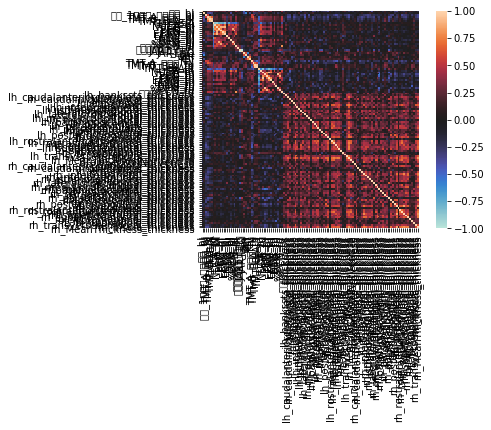

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matp,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_matp.columns.values,
            yticklabels=corr_matp.columns.values
           )
plt.show()
#fig = plt.figure(figsize=(10,10),dpi=200)
#fig.show()

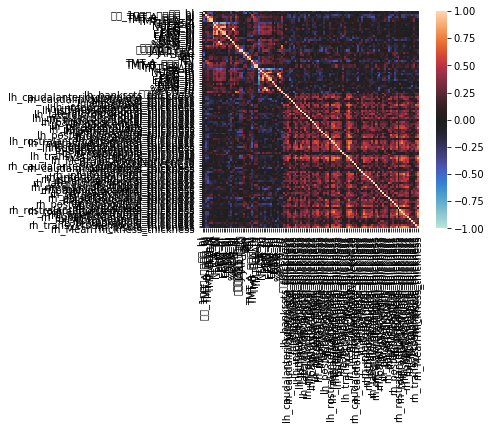

In [10]:
corr_mats = df_result.corr(method='spearman')
corr_mats=corr_mats.dropna(how = 'all')
corr_mats=corr_mats.dropna(axis = 'columns')
corr_mats.to_csv('/home/brain/Downloads/spc_corr_mats.csv')
sns.heatmap(corr_mats,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_mats.columns.values,
            yticklabels=corr_mats.columns.values
           )
plt.show()

In [11]:
print(corr_matp)

                                    年齢_bl  性別_1：男性_２：女性_bl  TMT-A_（秒）_bl  \
年齢_bl                            1.000000        -0.063785      0.018097   
性別_1：男性_２：女性_bl                 -0.063785         1.000000     -0.024579   
TMT-A_（秒）_bl                     0.018097        -0.024579      1.000000   
TMT-B_（秒）_bl                     0.263743        -0.346917      0.534483   
TMT_B-A_bl                       0.300908        -0.395327      0.019580   
...                                   ...              ...           ...   
rh_frontalpole_thickness         0.162190        -0.128591     -0.082334   
rh_temporalpole_thickness        0.104969        -0.086282     -0.266967   
rh_transversetemporal_thickness -0.112746        -0.033749     -0.144433   
rh_insula_thickness             -0.031535         0.038021     -0.252555   
rh_MeanThickness_thickness      -0.159934        -0.001043     -0.348230   

                                 TMT-B_（秒）_bl  TMT_B-A_bl   TMT_B/A     CA_bl  \
年齢_bl 

In [12]:
print(corr_mats)

                                    年齢_bl  性別_1：男性_２：女性_bl  TMT-A_（秒）_bl  \
年齢_bl                            1.000000        -0.054909      0.058551   
性別_1：男性_２：女性_bl                 -0.054909         1.000000     -0.050775   
TMT-A_（秒）_bl                     0.058551        -0.050775      1.000000   
TMT-B_（秒）_bl                     0.360843        -0.355422      0.496579   
TMT_B-A_bl                       0.259337        -0.441540     -0.135181   
...                                   ...              ...           ...   
rh_frontalpole_thickness         0.152373        -0.128843     -0.188690   
rh_temporalpole_thickness        0.032443        -0.007809     -0.322156   
rh_transversetemporal_thickness  0.036543        -0.042948     -0.201245   
rh_insula_thickness             -0.055404         0.000000     -0.302863   
rh_MeanThickness_thickness      -0.153227        -0.027332     -0.327200   

                                 TMT-B_（秒）_bl  TMT_B-A_bl   TMT_B/A     CA_bl  \
年齢_bl 